<a href="https://colab.research.google.com/github/hongwon2/HG-MLDL/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D2_%EA%B0%80%EC%A7%9C_%EB%89%B4%EC%8A%A4_%EB%B6%84%EB%A5%98_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 메소드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
!pip install contractions
import contractions
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score, \
                             recall_score, f1_score, roc_curve, \
                             accuracy_score, roc_auc_score
from sklearn.model_selection import ParameterGrid, GridSearchCV


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.layers import  Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, GRU, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping

from __future__ import absolute_import, division, print_function, unicode_literals

VOCAB_SIZE = 5000

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
  path = '/content/drive/MyDrive/kaggle_data/'
  test   = pd.read_csv(path + 'test.csv'  )
  train  = pd.read_csv(path + 'train.csv' )
  submit = pd.read_csv(path + 'submit.csv')

# 데이터 전처리

In [ ]:
def data_clean(dt):
  dt = dt.fillna('')
  dt["total"] = dt['title'] + " " + dt["author"]  
  return dt

In [ ]:
def text_cleaning(df):
    ps = PorterStemmer()
    corpus = []
    for i in range(len(df)):
        m = re.sub("[^a-zA-Z]", " ", df["total"][i])
        m = m.lower()
        m = m.split()
        m = [ps.stem(word) for word in m if not word in stopwords.words('english')]
        clean_text = " ".join(m)
        corpus.append(clean_text)
    return corpus

In [ ]:
def onehot(corpus, VOCAB_SIZE = 5000):
  return [one_hot(words, VOCAB_SIZE) for words in corpus]

In [ ]:
def padding(onehot_text) :
  return np.array(pad_sequences(onehot_text, padding="pre", maxlen = 25))

In [ ]:
def get_label(df):
  return np.array(df["label"])

In [ ]:
def make_clean(df) :
  corpus = data_clean(df)
  corpus = text_cleaning(corpus)
  corpus = onehot(corpus)
  corpus = padding(corpus)
  return   corpus

In [ ]:
def get_data() :
  path = '/content/drive/MyDrive/kaggle_data/'
  test   = pd.read_csv(path + 'test.csv'  )
  train  = pd.read_csv(path + 'train.csv' )
  submit = pd.read_csv(path + 'submit.csv')

  x = np.array(list(make_clean(train)) + list(make_clean(test )))
  y = np.array(list(get_label(train )) + list(get_label(submit)))
  return train_test_split(x, y, test_size = 0.1, random_state = 1234)

In [ ]:
def save_data(path, train_x, test_x, train_y, test_y) :
  np.save(path + 'train_x', train_x)
  np.save(path + 'test_x' , test_x )
  np.save(path + 'train_y', train_x)
  np.save(path + 'test_y' , test_x )

In [ ]:
train_x, test_x, train_y, test_y = get_data()

save_data(path, train_x, test_x, train_y, test_y)

In [ ]:
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size = 0.1,random_state = 1234)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(21060, 25)
(21060,)
(2340, 25)
(2340,)
(2600, 25)
(2600,)


#모델링

## RNN

In [ ]:
model_RNN = Sequential()
model_RNN.add(Embedding(30000, 30))
model_RNN.add(SimpleRNN(100))
model_RNN.add(Dense(1, activation='sigmoid'))
model_RNN.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['acc'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-RNN-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history_RNN = model_RNN.fit(train_x, train_y, epochs=10,
                    validation_data=(val_x, val_y),
                    callbacks=[checkpoint_cb, early_stopping_cb])
model_RNN.summary()

Epoch 1/10
659/659 [==============================] - 15s 21ms/step - loss: 0.3113 - acc: 0.8885 - val_loss: 0.2768 - val_acc: 0.9179
Epoch 2/10
659/659 [==============================] - 13s 19ms/step - loss: 0.2084 - acc: 0.9265 - val_loss: 0.2698 - val_acc: 0.9081
Epoch 3/10
659/659 [==============================] - 13s 19ms/step - loss: 0.1284 - acc: 0.9557 - val_loss: 0.3295 - val_acc: 0.8966
Epoch 4/10
659/659 [==============================] - 13s 20ms/step - loss: 0.0690 - acc: 0.9767 - val_loss: 0.4553 - val_acc: 0.8765
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 30)          900000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               13100     
                                                                 
 dense (Dense)               (None, 1)          

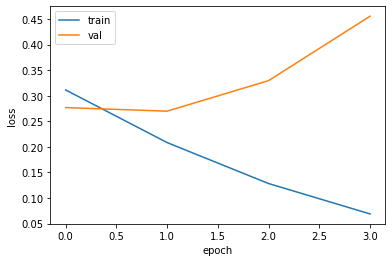

In [ ]:
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model_RNN.evaluate(val_x, val_y)

74/74 [==============================] - 0s 4ms/step - loss: 0.2698 - acc: 0.9081


[0.2698318064212799, 0.9081196784973145]

## LSTM

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(30000, 30))
model_LSTM.add(keras.layers.Dropout(0.3))
model_LSTM.add(LSTM(100))
model_LSTM.add(keras.layers.Dropout(0.3))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(keras.layers.Dropout(0.3))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['acc'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-LSTM-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history_LSTM = model_LSTM.fit(train_x, train_y, epochs=10,
                    validation_data=(val_x, val_y),
                    callbacks=[checkpoint_cb, early_stopping_cb])
model_LSTM.summary()

Epoch 1/10
659/659 [==============================] - 29s 40ms/step - loss: 0.3198 - acc: 0.8822 - val_loss: 0.2563 - val_acc: 0.9167
Epoch 2/10
659/659 [==============================] - 22s 34ms/step - loss: 0.2413 - acc: 0.9203 - val_loss: 0.2563 - val_acc: 0.9154
Epoch 3/10
659/659 [==============================] - 22s 34ms/step - loss: 0.2135 - acc: 0.9268 - val_loss: 0.2674 - val_acc: 0.9068
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 30)          900000    
                                                                 
 dropout (Dropout)           (None, None, 30)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               52400     
                                                                 
 dropout_1 (Dropout)         (None, 100)        

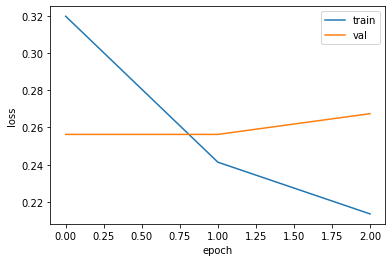

In [ ]:
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model_LSTM.evaluate(val_x, val_y)

74/74 [==============================] - 1s 8ms/step - loss: 0.2563 - acc: 0.9167


[0.2562750577926636, 0.9166666865348816]

## GRU

In [ ]:
model_GRU = Sequential()
model_GRU.add(Embedding(30000, 64))
model_GRU.add(keras.layers.Dropout(0.3))
model_GRU.add(GRU(64))
model_GRU.add(keras.layers.Dropout(0.3))
model_GRU.add(Dense(16, activation='relu'))
model_GRU.add(keras.layers.Dropout(0.3))
model_GRU.add(Dense(1, activation='sigmoid'))
model_GRU.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['acc'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-GRU-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history_GRU = model_GRU.fit(train_x, train_y, epochs=10,
                    validation_data=(val_x, val_y),
                    callbacks=[checkpoint_cb, early_stopping_cb])
model_GRU.summary()

Epoch 1/10
659/659 [==============================] - 27s 38ms/step - loss: 0.3239 - acc: 0.8896 - val_loss: 0.2517 - val_acc: 0.9167
Epoch 2/10
659/659 [==============================] - 24s 36ms/step - loss: 0.2475 - acc: 0.9217 - val_loss: 0.2542 - val_acc: 0.9167
Epoch 3/10
659/659 [==============================] - 24s 37ms/step - loss: 0.2166 - acc: 0.9268 - val_loss: 0.2823 - val_acc: 0.9090
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          1920000   
                                                                 
 dropout_3 (Dropout)         (None, None, 64)          0         
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dropout_4 (Dropout)         (None, 64)         

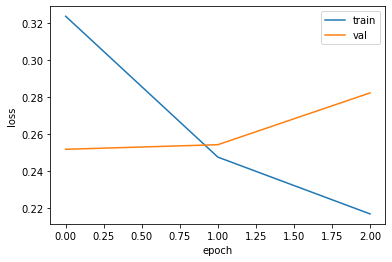

In [ ]:
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model_GRU.evaluate(val_x, val_y)

74/74 [==============================] - 0s 5ms/step - loss: 0.2517 - acc: 0.9167


[0.2517031133174896, 0.9166666865348816]

## CNN-LSTM


In [ ]:
train_x.shape

(21060, 25)

In [ ]:
model_CNN_LSTM = Sequential()
model_CNN_LSTM.add(keras.layers.Embedding(30000, 30))
model_CNN_LSTM.add(keras.layers.Dropout(0.3))
model_CNN_LSTM.add(keras.layers.Conv1D(32, 3, padding='same', strides=1,activation='relu'))
model_CNN_LSTM.add(keras.layers.MaxPooling1D(2))
model_CNN_LSTM.add(LSTM(100))
model_CNN_LSTM.add(keras.layers.Dropout(0.3))
model_CNN_LSTM.add(Dense(1, activation='sigmoid'))
model_CNN_LSTM.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['acc'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-CNN_LSTM-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history_CNN_LSTM = model_CNN_LSTM.fit(train_x, train_y, epochs=10,
                    validation_data=(val_x, val_y),
                    callbacks=[checkpoint_cb, early_stopping_cb])
model_CNN_LSTM.summary()



Epoch 1/10
659/659 [==============================] - 22s 30ms/step - loss: 0.3328 - acc: 0.8706 - val_loss: 0.2568 - val_acc: 0.9201
Epoch 2/10
659/659 [==============================] - 19s 28ms/step - loss: 0.2431 - acc: 0.9221 - val_loss: 0.2694 - val_acc: 0.9171
Epoch 3/10
659/659 [==============================] - 19s 28ms/step - loss: 0.2156 - acc: 0.9274 - val_loss: 0.2740 - val_acc: 0.9111
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, None, 30)          900000    
                                                                 
 dropout_55 (Dropout)        (None, None, 30)          0         
                                                                 
 conv1d_37 (Conv1D)          (None, None, 32)          2912      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, None, 32) 

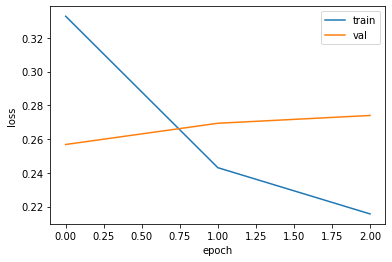

In [ ]:
plt.plot(history_CNN_LSTM.history['loss'])
plt.plot(history_CNN_LSTM.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model_CNN_LSTM.evaluate(val_x, val_y)

74/74 [==============================] - 1s 7ms/step - loss: 0.2568 - acc: 0.9201


[0.2568093240261078, 0.9200854897499084]

# 최종평가 : test set 예측 

In [ ]:
def show_metrics(y_pred, y_actual) :
  print('Accuracy  :',  accuracy_score(y_pred, y_actual))
  print('Precision :', precision_score(y_pred, y_actual))
  print('Recall    :',    recall_score(y_pred, y_actual))
  print('F1-score  :',        f1_score(y_pred, y_actual))
  print('Auc       :',   roc_auc_score(y_pred, y_actual))

In [ ]:
def show_confusion_matrix(y_pred, y_actual, path, model_name) :
  fig = plt.figure(figsize = (10, 8))
  plt.title(model_name + ' Confusion Matrix')
  sns.heatmap(confusion_matrix(y_pred, y_actual), annot = True, fmt = 'd', 
              cbar = False, cmap = sns.color_palette("Purples",2),
              xticklabels = ['Positive', 'Negative'],
              yticklabels = ['Positive', 'Negative'])
  plt.xlabel('Actuals')
  plt.ylabel('Predicted')
  plt.savefig(path + model_name +'_confusion_matrix.png', dpi = 300)
  plt.show()

In [ ]:
model_CNN_LSTM.evaluate(test_x,test_y)

82/82 [==============================] - 1s 11ms/step - loss: 0.2820 - acc: 0.9123


[0.2819856107234955, 0.9123076796531677]

In [ ]:
y_pred = (model_CNN_LSTM.predict(test_x) > 0.5).astype("int32")
path2 = '/content/drive/MyDrive/ML2/'
model_CNN_LSTM.save(path2 + 'CNN_LSTM.h5')

82/82 [==============================] - 1s 6ms/step


Accuracy  : 0.9123076923076923
Precision : 0.905446293494705
Recall    : 0.9207692307692308
F1-score  : 0.9130434782608696
Auc       : 0.9123076923076924


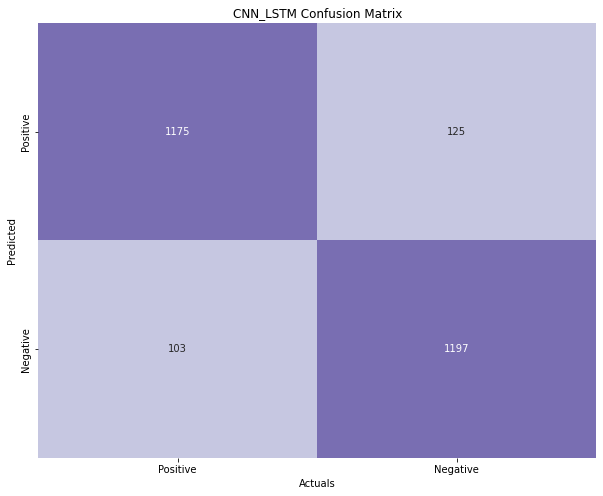

In [ ]:
show_metrics(y_pred, test_y)
show_confusion_matrix(y_pred, test_y, path2, 'CNN_LSTM')